## This set of code is used to run and create single or sets of simulations. Included at the top are the packages required to run this code, an initilization cell which sets the arbitrary cell area as one, and all of the defined functions which allow the simulation to run, as described in the read-me. 

### After the first three cells are examples of how to run a simulation and generate the images to be put into a movie. I've assembled my movies in FIJI. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import os
import time, sys
from IPython.display import clear_output
import math
import pickle
import networkx as nx

plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
number_of_sides = 40
natural_cell_area = 1
natural_cell_radius = np.sqrt(natural_cell_area/np.pi)
natural_spacing = 2*np.pi*natural_cell_radius/number_of_sides

In [3]:
def make_cells(**kwargs):
    np.random.seed(kwargs.get('seed', 2*21*1995))
    scatter = kwargs.get('scatter', natural_cell_radius*0.1)
    compression = kwargs.get('compression', False)
    theta = np.linspace(0, 2*np.pi, number_of_sides+1)[:-1].copy()
    list_of_cells = []
    for i in range(len(centers)):
        cell = np.zeros([number_of_sides, 2])
        cell[:,0] = natural_cell_radius*np.cos(theta)+centers[i,0]
        cell[:,1] = natural_cell_radius*np.sin(theta)+centers[i,1]
        cell = cell+scatter*np.random.random([number_of_sides,2])
        list_of_cells.append(cell)
    if not compression:
        left_min = np.min([-3, 2*(np.min(centers[:,0])-natural_cell_radius)])
        right_max = np.max([3, 2*(np.max(centers[:,0])+natural_cell_radius)])
    else:
        left_min = compression[0]
        right_max = compression[1]
    floorx = np.linspace(left_min, right_max, int((right_max-left_min)/natural_spacing))
    floorz = np.zeros_like(floorx)
    floor = np.array([floorx,floorz]).transpose()
    return floor, list_of_cells

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

def plot_cells(list_of_cells, **kwargs):
    connections = kwargs.get('connections',False)
    CCid = kwargs.get('CCid', 0.16)
    CSid = kwargs.get('CSid', 0.1)
    cell_cell, cell_cell_pairs = cell_cell_interactions(list_of_cells, CCid)
    sub_cell, sub_cell_pairs = cell_substrate_interactions(list_of_cells, CSid)
    left_min = -4.5
    right_max = 4.5
    top = 1.25*(np.max(centers[:,1])+natural_cell_radius)
    bottom = -0.2
    save_name = kwargs.get('save_name', False)
    fig = plt.figure(figsize = (12,12))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.set_xlim([left_min,right_max])
    ax.set_ylim([bottom,top])
    for i in range(len(list_of_cells)):
        if connections == True:
            cell_i = list_of_cells[i]
            if len(sub_cell)>0:
                c_pts = cell_i[sub_cell_pairs[:,1].astype('int')[sub_cell==i]]
                s_pts = floor[sub_cell_pairs[:,0].astype('int')[sub_cell==i]]
                for j in range(len(c_pts)):
                    x = [c_pts[j][0], s_pts[j][0]]
                    y = [c_pts[j][1], s_pts[j][1]]
                    ax.plot(x,y, c = 'deepskyblue', linewidth = 2)
            for j in range(len(list_of_cells)):
                cell_j = list_of_cells[j]
                if len(cell_cell)>0:
                    con_ij = np.logical_and(cell_cell[:,0]==i, cell_cell[:,1]==j)
                    if np.sum(con_ij) > 0:
                        ci_pts = cell_i[cell_cell_pairs[:,0].astype('int')[con_ij]]
                        cj_pts = cell_j[cell_cell_pairs[:,1].astype('int')[con_ij]]
                        for k in range(len(ci_pts)):
                            x = [ci_pts[k][0],cj_pts[k][0]]
                            y = [ci_pts[k][1],cj_pts[k][1]]
                            ax.plot(x,y,c='darkgreen', linewidth = 3.5)
        ax.scatter(list_of_cells[i][:,0], list_of_cells[i][:,1], color = 'k')
        ax.plot(list_of_cells[i][:,0], list_of_cells[i][:,1], color = 'k')
        ax.plot([list_of_cells[i][0,0], list_of_cells[i][-1,0]], 
                [list_of_cells[i][0,1], list_of_cells[i][-1,1]], color = 'k')
    ax.scatter(floor, np.zeros_like(floor), color = 'r', alpha = 0.5)
    ax.plot(floor, np.zeros_like(floor), color = 'r', alpha = 0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    if save_name != False:
        plt.savefig(save_name+'.pdf', bbox_inches = 'tight', pad_inches = 1)
    return

def make_movie_images(list_of_configurations, save_name, **kwargs):
    frame_freq = kwargs.get('frame_freq', 1)
    connections = kwargs.get('connections', False)
    os.mkdir(save_name)
    numb_frames = math.floor(len(list_of_configurations)/frame_freq)
    for i in range(numb_frames):
        plot_cells(list_of_configurations[frame_freq*i], connections = connections)
        plt.savefig(save_name + '/' + save_name + '_' + str(frame_freq*i) + '.pdf', bbox_inches = 'tight', pad_inches = 1)
        clear_output()
    return

def area(cell):
#This function calculates the area of a cell in the model. As always
#the input cell should be an Nx2 numpy array. The output will be a 
#scalar float equal to the area of the cell. 
    x = cell[:,0]
    z = cell[:,1]
#To calculate cell area, I employ the shoelace formula for calculating
#the area of any simple polygon. The numpy function np.roll will rotate 
#the elements of an array +- one position and will bring the first element
#to the end or last element to the beginnng. 
    return 0.5*np.sum(x*np.roll(z,-1)-z*np.roll(x,-1))

def distance_matrix(xz1, xz2):
    mutx1 = np.outer(np.ones(len(xz2[:,0])), xz1[:,0])
    mutz1 = np.outer(np.ones(len(xz2[:,0])), xz1[:,1])
    mutx2 = np.outer(xz2[:,0], np.ones(len(xz1[:,0])))
    mutz2 = np.outer(xz2[:,1], np.ones(len(xz1[:,0])))
    return np.sqrt((mutx1-mutx2)**2+(mutz1-mutz2)**2).transpose()

def cell_substrate_interactions(list_of_cells, substrate_interaction_distance):
    all_distances = []
    cell_matrix_distances = []
    closest_cell_points = np.zeros([len(floor), len(list_of_cells)])
    closest_substrate_points = []
    i = 0
    for cell in list_of_cells:
        distances = distance_matrix(floor, cell)
        all_distances.append(distances)
        cell_matrix_distances.append(distances)
        closest_substrate_points.append(np.min(distances, axis = 0)<=substrate_interaction_distance)
        closest_cell_points[:,i] = np.min(distances, axis = 1)
        i+=1
    floor_interactions = np.min(closest_cell_points, axis = 1)<=substrate_interaction_distance
    floor_interaction_distances = closest_cell_points[floor_interactions]
    
    which_cell = np.zeros(np.sum(floor_interactions))
    which_pair = np.zeros([np.sum(floor_interactions),2])
    for j in range(len(floor_interactions[floor_interactions])):
        which_cell[j] = np.argwhere(floor_interaction_distances[j,:]==np.min(floor_interaction_distances[j,:]))[0,0]
        which_pair[j] = np.argwhere(cell_matrix_distances[int(which_cell[j])] == np.min(closest_cell_points, axis = 1)[floor_interactions][j])[0]
    
    which_cell_2 = []
    which_pair_2 = []
    for k in range(len(list_of_cells)):
        this_cell = which_cell==k
        this_cell_pairs = which_pair[this_cell]
        repeats = []
        for l in range(np.sum(this_cell)):
            if np.sum(this_cell_pairs[:,1]==this_cell_pairs[l,1])>1:
                repeats.append(this_cell_pairs[l,1])
            else:
                which_cell_2.append(k)
                which_pair_2.append(this_cell_pairs[l])
        repeats = np.sort(list(set(repeats)))
        for item in repeats:
            checks = this_cell_pairs[this_cell_pairs[:,1]==item]
            dists = []
            for m in range(len(checks)):
                dists.append(all_distances[k][int(checks[m][0]),int(checks[m][1])])
            keep = np.argwhere(dists == np.min(dists))[0,0]
            which_cell_2.append(k)
            which_pair_2.append(checks[keep])
                
    
    return np.array(which_cell_2), np.array(which_pair_2)

def cell_cell_interactions(list_of_cells, cell_cell_interaction_distance):
    center_positions = np.zeros([len(list_of_cells),2])
    for i in range(len(list_of_cells)):
        cell_centers = list_of_cells[i].mean(0)
        center_positions[i,0] = cell_centers[0]
        center_positions[i,1] = cell_centers[1]
    dist_bt_cell_centers = distance_matrix(center_positions,center_positions)
    pairs_of_cells_that_matter = np.argwhere(dist_bt_cell_centers>0)
    cells_that_matter = []
    for i in range(len(pairs_of_cells_that_matter)):
        if pairs_of_cells_that_matter[i,0]<pairs_of_cells_that_matter[i,1]:
            cells_that_matter.append(pairs_of_cells_that_matter[i])
    list_of_pairs = []
    for i in range(len(cells_that_matter)):
        cell_1 = list_of_cells[int(cells_that_matter[i][0])]
        cell_2 = list_of_cells[int(cells_that_matter[i][1])]
        distances = distance_matrix(cell_1,cell_2)
        closest_cell_cell_points = np.min(distances, axis = 1)
        cell_interactions = closest_cell_cell_points<=cell_cell_interaction_distance
        cell_interaction_distances = closest_cell_cell_points[cell_interactions]
        if np.sum(cell_interactions) == 0:
            which_pair = []
        else:
            which_pair = np.zeros([np.sum(cell_interactions),2])
            for j in range(np.sum(cell_interactions)):
                which_pair[j] = np.argwhere(distances == cell_interaction_distances[j])[0]
        list_of_pairs.append(which_pair)
    what_cells = []
    what_pairs = []
    which_cells = []
    which_pairs = []
    for i in range(len(cells_that_matter)):
        for j in range(len(list_of_pairs[i])):
            pairs = list_of_pairs[i][j]
            what_pairs.append(pairs)
            cells = [cells_that_matter[i]]
            what_cells.append(cells)
            which_pairs = np.vstack(what_pairs)
            which_cells= np.vstack(what_cells)

    if len(which_cells)>0:
        which_cells_2 = []
        which_pairs_2 = []
        for k in range(len(list_of_cells)):
            for n in range(len(list_of_cells)):
                these_cells = np.logical_and(which_cells[:,0]==k, which_cells[:,1]==n)
                these_cell_pairs = which_pairs[these_cells]
                repeats = []
                for l in range(np.sum(these_cells)):
                    if np.sum(these_cell_pairs[:,1]==these_cell_pairs[l,1])>1:
                        repeats.append(these_cell_pairs[l,1])
                    else:
                        which_cells_2.append([k,n])
                        which_pairs_2.append(these_cell_pairs[l])
                repeats = np.sort(list(set(repeats)))
                for item in repeats:
                    checks = these_cell_pairs[these_cell_pairs[:,1]==item]
                    dists = []
                    for m in range(len(checks)):
                        dists.append(distance_matrix(list_of_cells[k], list_of_cells[n])[int(checks[m][0]),int(checks[m][1])])
                    keep = np.argwhere(dists == np.min(dists))[0,0]
                    which_cells_2.append([k,n])
                    which_pairs_2.append(checks[keep])
    else:
        which_cells_2 = which_cells
        which_pairs_2 = which_pairs
        
    if len(np.array(which_cells_2))>0:
        return np.concatenate([np.array(which_cells_2), np.array(which_cells_2)[:,[1,0]]]), np.concatenate([np.array(which_pairs_2), np.array(which_pairs_2)[:,[1,0]]])
    else:
        return np.array(which_cells_2), np.array(which_pairs_2)

#NOT YET USED, FROM ALEX TO FIX A BUG
# def new_cell_cell_interactions(list_of_cells, d_cell_cell):
#     all_node_node_contacts = []
#     all_cell_cell_contacts = []
#     all_node_node_separations = []

#     # Iterate over cell pairs (i, j) with j > i
#     for i, j in combinations(range(len(list_of_cells)), 2):

#         # Calculate all node pair distances for this cell pair
#         node_node_ds = distance_matrix(list_of_cells[i], list_of_cells[j])
        
#         # Option 1 (not used): Store any node pairs that are within the threshold distance apart
#         # node_node_contacts = np.argwhere(node_node_ds < d_cell_cell).tolist()

#         # Option 2: Store any node pairs that are within the threshold distance apart, but allow a maximum of one connection from each node in cell i to cell j (the node with lowest index in cell j) 
#         # and from each node in cell j to cell i (the node with lowest index in cell i)
#         ds_from_cell_i = np.min(node_node_ds, axis=1)
#         ds_to_cell_j = np.min(node_node_ds, axis=0)
#         node_node_contacts = np.argwhere((node_node_ds < d_cell_cell) & 
#                                          (node_node_ds == np.min(node_node_ds, axis=1)[:, np.newaxis]) & 
#                                          (node_node_ds == np.min(node_node_ds, axis=0))).tolist()

#         # Store the cell pair to which each node pair belongs
#         if node_node_contacts:
#             all_node_node_contacts += node_node_contacts
#             all_cell_cell_contacts += [[i, j]] * len(node_node_contacts)
#             all_node_node_separations += [node_node_ds[tuple(x)] for x in node_node_contacts]

#     # Option 3: As in option 2, but also allow a maximum of one connection from each node to ANY cell
#     indices_to_remove = set()
#     for i, (contacts_i, separations_i) in enumerate(zip(all_cell_cell_contacts, all_node_node_separations)):
#         for j, (contacts_j, separations_j) in enumerate(zip(all_cell_cell_contacts[i + 1:], all_node_node_separations[i + 1:]), start=i + 1):
#             if ((contacts_i[0] == contacts_j[0]) and (all_node_node_contacts[i][0] == all_node_node_contacts[j][0])) or \
#                 ((contacts_i[1] == contacts_j[1]) and (all_node_node_contacts[i][1] == all_node_node_contacts[j][1])) or \
#                 ((contacts_i[0] == contacts_j[1]) and (all_node_node_contacts[i][0] == all_node_node_contacts[j][1])) or \
#                 ((contacts_i[1] == contacts_j[0]) and (all_node_node_contacts[i][1] == all_node_node_contacts[j][0])):
#                 if separations_i >= separations_j:
#                     indices_to_remove.add(i)
#                 else:
#                     indices_to_remove.add(j)

#     all_cell_cell_contacts = [contacts for i, contacts in enumerate(all_cell_cell_contacts) if i not in indices_to_remove]
#     all_node_node_contacts = [contacts for i, contacts in enumerate(all_node_node_contacts) if i not in indices_to_remove]
#     all_node_node_separations = [separation for i, separation in enumerate(all_node_node_separations) if i not in indices_to_remove]

#     # Duplicate the arrays of cell pairs and node pairs (probably not needed)
#     if all_cell_cell_contacts:
#         all_cell_cell_contacts = np.array(all_cell_cell_contacts)
#         all_node_node_contacts = np.array(all_node_node_contacts)
#         return np.concatenate([all_cell_cell_contacts, all_cell_cell_contacts[:, [1, 0]]]), \
#                np.concatenate([all_node_node_contacts, all_node_node_contacts[:, [1, 0]]])

#     return np.array(all_cell_cell_contacts), np.array(all_node_node_contacts)

def spreading(cell, sub_cell_pts, spreading_strength):
    force = np.zeros_like(cell)
    pt1 = int(np.min(sub_cell_pts) - 1)
    pt2 = int(np.max(sub_cell_pts) + 1)%len(cell)
    if cell[:,0][pt1]<cell[:,0][pt2]:
        left_point = pt1
        right_point = pt2
    else:
        left_point = pt2
        right_point = pt1
    x = spreading_strength*np.cos(np.pi/4)
    z = spreading_strength*np.sin(np.pi/4)
    force[left_point] = [-x, -z]
    force[right_point] = [x, -z]
    return force, left_point, right_point

def internal_force_on_cell(cell, kA, kL, cell_cycle, time_step, **kwargs):
    ls = np.sqrt(np.sum((np.roll(cell, -1, axis = 0) - cell)**2, axis = 1))

    if cell_cycle >= time_step*17000 and cell_cycle <= time_step*18000:
        kA = 0.05
        kL = 5*kL
        force_from_area = np.zeros_like(cell)
        force_from_area[:,0] = (-kA*(abs(area(cell))-(natural_cell_area*((1+((cell_cycle-time_step*17000)/(time_step*1000))))))*area(cell)/abs(area(cell))*
                            (np.roll(cell[:,1],-1)-np.roll(cell[:,1],1)))
        force_from_area[:,1] = (-kA*(abs(area(cell))-(natural_cell_area*((1+((cell_cycle-time_step*17000)/(time_step*1000))))))*area(cell)/abs(area(cell))*
                            (np.roll(cell[:,0],1)-np.roll(cell[:,0],-1)))
           
    else:
        force_from_area = np.zeros_like(cell)
        force_from_area[:,0] = (-kA*(abs(area(cell))-natural_cell_area)*area(cell)/abs(area(cell))*
                                (np.roll(cell[:,1],-1)-np.roll(cell[:,1],1)))
        force_from_area[:,1] = (-kA*(abs(area(cell))-natural_cell_area)*area(cell)/abs(area(cell))*
                                (np.roll(cell[:,0],1)-np.roll(cell[:,0],-1)))

    force_from_membrane = np.zeros_like(cell)
    force_from_membrane[:,0] = (-kL*np.sum(ls)*((cell[:,0]-np.roll(cell[:,0],1))/np.roll(ls,1)-
                                                (np.roll(cell[:,0],-1)-cell[:,0])/ls))
    force_from_membrane[:,1] = (-kL*np.sum(ls)*((cell[:,1]-np.roll(cell[:,1],1))/np.roll(ls,1)-
                                                (np.roll(cell[:,1],-1)-cell[:,1])/ls))
    
    return force_from_area+force_from_membrane

def total_force_on_cells(list_of_cells, kA, kL, kAC, gCS, gCC, substrate_interaction_distance, cell_interaction_distance, spreading_strength, cell_cycles, time_step):
    
    cell_cell, cell_cell_pairs = cell_cell_interactions(list_of_cells, cell_interaction_distance)
    cell_cell_extended, cell_cell_pairs_extended = cell_cell_interactions(list_of_cells, 1.2*cell_interaction_distance)
    sub_cell, sub_cell_pairs = cell_substrate_interactions(list_of_cells, substrate_interaction_distance)
    network = np.identity(len(list_of_cells)+1)
    
    #Calculates the total force from cell-cell contacts and makes a simple network for the connectivity 
    #between cells. 
    cell_cell_forces = []
    if len(cell_cell)>0:
        for i in range(len(list_of_cells)):
            cell_i = list_of_cells[i]
            force_on_i = np.zeros_like(cell_i)
            if np.sum(sub_cell==i)>0:
                gCC_altered = (1+np.sum(sub_cell==i)*0.03)*gCC
            else:
                gCC_altered = gCC
            if np.sum(sub_cell==i)>0:
                network[i+1,0] = 1
                network[0,i+1] = 1
            if np.sum(cell_cell[:,0]==i)>0:
                cell_cell_to_use, cell_cell_pairs_to_use = cell_cell_extended, cell_cell_pairs_extended
            else:
                cell_cell_to_use, cell_cell_pairs_to_use = cell_cell, cell_cell_pairs
            for j in range(len(list_of_cells)):
                cell_j = list_of_cells[j]
                con_ij = np.logical_and(cell_cell_to_use[:,0]==i, cell_cell_to_use[:,1]==j)
                if np.sum(con_ij) > 0:
                    ci_pts = cell_i[cell_cell_pairs_to_use[:,0].astype('int')[con_ij]]
                    cj_pts = cell_j[cell_cell_pairs_to_use[:,1].astype('int')[con_ij]]
                    distances = np.sum((ci_pts-cj_pts)**2, axis = 1)
                    distances_dub = np.vstack([distances, distances]).transpose()
                    attract = distances > 0.005
                    repel = distances <= 0.005
                    force_on_i[cell_cell_pairs_to_use[:,0].astype('int')[con_ij][attract]] = (gCC_altered*(cj_pts-ci_pts)*(distances_dub-0.005)/distances_dub)[attract]
                    ### REPULSIVE CELL FORCES ARE BELOW THIS LINE
                    force_on_i[cell_cell_pairs_to_use[:,0].astype('int')[con_ij][repel]] = (0.05*(cj_pts-ci_pts)*(distances_dub-0.005)/distances_dub)[repel]
                    network[i+1,j+1] = 1
                    
            cell_cell_forces.append(force_on_i)

    else:
        for i in range(len(list_of_cells)):
            cell_cell_forces.append(np.zeros_like(list_of_cells[i]))
            if np.sum(sub_cell==i)>0:
                network[i+1,0] = 1
                network[0,i+1] = 1
    G = nx.from_numpy_matrix(network)
    #Sum together remaining forces with slight alterations if active conditions are met. 
    list_of_total_forces = []
    for i in range(len(list_of_cells)):
        cell = list_of_cells[i]
        internal_force = internal_force_on_cell(cell, kA, kL, cell_cycles[i], time_step)
        external_force = np.zeros_like(cell)
        spreading_force = np.zeros_like(cell)
        if len(sub_cell)>0 and cell_cycles[i]<=time_step*17000:
            if np.sum(nx.convert_matrix.to_numpy_array(G)[:,i+1])>2:
                gCS_altered = gCS*1.5
            else:
                gCS_altered = gCS
            c_pts = cell[sub_cell_pairs[:,1].astype('int')[sub_cell==i]]
            s_pts = floor[sub_cell_pairs[:,0].astype('int')[sub_cell==i]]
            distances = np.sum((c_pts-s_pts)**2, axis = 1)
            distances = np.vstack([distances, distances]).transpose()
            external_force[sub_cell_pairs[:,1].astype('int')[sub_cell==i]] = gCS_altered*(s_pts-c_pts)*(distances-0.001)/distances
            if np.sum(sub_cell==i)>3:
                spreading_force, left_point, right_point = spreading(cell, sub_cell_pairs[sub_cell==i][:,1], spreading_strength)
                if np.any(cell_cell_forces[i][(left_point-len(cell)//8):left_point]!=0):
                    spreading_force[left_point] = [0,0]
                if np.any(cell_cell_forces[i][right_point+1:right_point+len(cell)//8+1]!=0):
                    spreading_force[right_point] = [0,0]
        elif len(sub_cell)>0:
            if np.sum(nx.convert_matrix.to_numpy_array(G)[:,i+1])>2:
                gCS_altered = gCS*1.5
            else:
                gCS_altered = gCS
            c_pts = cell[sub_cell_pairs[:,1].astype('int')[sub_cell==i]]
            s_pts = floor[sub_cell_pairs[:,0].astype('int')[sub_cell==i]]
            distances = np.sum((c_pts-s_pts)**2, axis = 1)
            distances = np.vstack([distances, distances]).transpose()
            external_force[sub_cell_pairs[:,1].astype('int')[sub_cell==i]] = 0
        gravity = np.zeros_like(list_of_cells[i])
        if nx.has_path(G,0,i+1):
            pass
        else:
            gravity[:,1] = -0.001*np.ones(len(list_of_cells[i][:,1])) 
        total_force = internal_force + external_force + spreading_force + cell_cell_forces[i] + gravity
        total_force[:,1] = total_force[:,1]*np.logical_or((cell[:,1]>0.01),(total_force[:,1]>0))
        list_of_total_forces.append(total_force)
    return list_of_total_forces

def cell_cortex_redistribution(cell):
    maximum_length = 2*natural_spacing
    minimum_length = 0.5*natural_spacing
    ls = np.sqrt(np.sum((np.roll(cell, -1, axis = 0) - cell)**2, axis = 1))
    if np.sum(ls>maximum_length) or np.sum(ls<minimum_length):
        points_to_add = np.argwhere(ls >= maximum_length)[:,0]
        new_point_locations = (cell[points_to_add] + np.roll(cell, -1, axis = 0)[points_to_add])/2
        aux = np.insert(cell, points_to_add+1, new_point_locations, axis = 0)
        ls = np.sqrt(np.sum((np.roll(aux, -1, axis = 0) - aux)**2, axis = 1))
        points_to_remove = np.argwhere(ls <= minimum_length)[:,0]
        which_removal = ls[(points_to_remove+1)%len(ls)]>ls[(points_to_remove-1)%len(ls)]
        remove_indicies = np.zeros_like(points_to_remove)
        remove_indicies[which_removal] = points_to_remove[which_removal]
        remove_indicies[np.invert(which_removal)] = (points_to_remove[np.invert(which_removal)]+1)%len(cell)
        redistributed_cell = np.delete(aux, remove_indicies, axis = 0)
    else:
        redistributed_cell = cell
    return redistributed_cell

def cell_remodeling(list_of_cells, cell_cycles, time_step):
    new_list = []
    new_cell_cycles = []
    maximum_length = 2*natural_spacing
    minimum_length = 0.5*natural_spacing
    for i in range(len(list_of_cells)):
        cell = list_of_cells[i]
        if cell_cycles[i] < time_step*18000:
            new_list.append(cell_cortex_redistribution(cell))
            new_cell_cycles.append(cell_cycles[i]+1)
        
        else:
            top = np.argwhere(cell[:,1] == np.max(cell[:,1]))[0][0]
            bot = np.argwhere(cell[:,1] == np.min(cell[:,1]))[0][0]
            cell_1 = cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell[top+1:bot-1].copy()))))))))))))))
            cell_2 = cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(cell_cortex_redistribution(np.delete(cell, slice(top-1,bot+1), axis = 0)))))))))))))))
            new_list.append(cell_1)
            new_list.append(cell_2)
            new_cell_cycles.append(np.random.randint(0,time_step*3000))
            new_cell_cycles.append(np.random.randint(0,time_step*3000))

    return new_list, new_cell_cycles

def move_points(list_of_cells, kA, kL, kAC, gCS, gCC, substrate_interaction_distance, cell_interaction_distance, spreading_strength, viscosity, cell_cycles, time_step):
    new_list = []
    list_of_total_forces = total_force_on_cells(list_of_cells, kA, kL, kAC, gCS, gCC, substrate_interaction_distance, cell_interaction_distance, spreading_strength, cell_cycles, time_step)
    for i in range(len(list_of_cells)):
        new_positions = list_of_total_forces[i]/(time_step*viscosity) + list_of_cells[i]
        new_positions[:,1] = new_positions[:,1]*(new_positions[:,1]>=0)
        new_list.append(new_positions)
    return new_list
    
def time_evolve(list_of_cells, **kwargs):
    iterations = kwargs.get('iterations', 15000)
    N_steps = int(iterations)
    kA = kwargs.get('kA', 1)
    kL = kwargs.get('kL', 0.0005)
    kAC = kwargs.get('kAC', 0.001)
    viscosity = kwargs.get('viscosity', 1)
    gCS = kwargs.get('gCS', 0.1)
    gCC = kwargs.get('gCC', 0.001)
    substrate_interaction_distance = kwargs.get('substrate_interaction_distance', 0.1)
    cell_interaction_distance = kwargs.get('cell_interaction_distance', 0.16)
    spreading_strength = kwargs.get('spreading_strength', 0.008)
    time_step = kwargs.get('time_step', 1)
    cell_cycles = kwargs.get('cell_cycles', list(np.random.randint(0, time_step*3000, len(list_of_cells))))
    list_of_configurations = [list_of_cells]
    list_of_cell_cycles = [cell_cycles]
    for i in range(N_steps):
        
        try:
            aux = list_of_configurations[i]
            aux, new_cell_cycles = cell_remodeling(aux, cell_cycles, time_step)
            list_of_configurations.append(move_points(aux, kA, kL, kAC, gCS, gCC, substrate_interaction_distance, cell_interaction_distance, spreading_strength, viscosity, new_cell_cycles, time_step))            
            cell_cycles = new_cell_cycles
            list_of_cell_cycles.append(new_cell_cycles)
            update_progress(i / N_steps)
        except:   
            return list_of_configurations
        
#         aux = list_of_configurations[i]
#         aux, new_cell_cycles = cell_remodeling(aux, cell_cycles, time_step)
#         list_of_configurations.append(move_points(aux, kA, kL, kAC, gCS, gCC, substrate_interaction_distance, cell_interaction_distance, spreading_strength, viscosity, new_cell_cycles, time_step))            
#         cell_cycles = new_cell_cycles
#         list_of_cell_cycles.append(new_cell_cycles)
#         update_progress(i / N_steps)
        
    update_progress(1)
    return list_of_configurations

def save_timepoint(list_of_cells, save_name):
    with open(save_name+'.pkl', 'wb') as f:
        pickle.dump(list_of_cells, f)
    return

### The cell below initializes the cells onto a substrate.

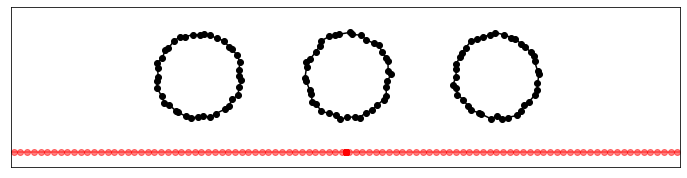

In [17]:
centers = np.array([[-2,1],[0,1],[2,1]])
#centers = np.array([[-2.4,1.5], [-0.8,1.5], [0.8,1.5], [2.4,1.5]])
#centers = np.array([[-5.6,1.5],[-4,1.5],[-2.4,1.5], [-0.8,1.5], [0.8,1.5], [2.4,1.5],[4,1.5],[5.6,1.5]])
floor, list_of_cells = make_cells(seed = 2*21*95, compression = [-5,5])
plot_cells(list_of_cells, connections = True)#, save_name = 'Cell Start')

In [21]:
toc = time.time()
list_of_configurations = time_evolve(list_of_cells, kA = 1, kL = 0.0005, kAC = 0.005, gCS = 0.1, gCC = 0.001, substrate_interaction_distance = 0.1, cell_interaction_distance = 0.16, spreading_strength = 0.008, iterations = 15000, viscosity = 1, time_step = 1, cell_cycles = [1,10000,1])
tic = time.time()
print(tic-toc)

Progress: [####################] 100.0%
244.7404270172119


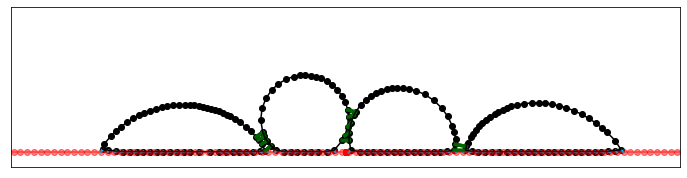

In [23]:
plot_cells(list_of_configurations[-1], connections = True)#, save_name = 'From4 - 0_0005kAC 20k@10')

### Make the frames of a Movie.

In [ ]:
make_movie_images(list_of_configurations, 'exponential fixed 3', frame_freq = 500, connections = True)